<a href="https://colab.research.google.com/github/kimdesok/VNet-3D-Instance-Segmentation/blob/master/3DMnist_by_3D_CNN_3DConvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, adam
import plotly.graph_objs as go

from keras.models import Model
from keras.utils.np_utils import to_categorical
import numpy as np
import pandas as pd

import keras
import h5py

init_notebook_mode(connected=True)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import seaborn as sns
import os
#print(os.listdir("../input"))

In [ ]:
with h5py.File('/content/drive/My Drive/3d/full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

In [ ]:
print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)

print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


In [ ]:
y_train[1], y_test[1]

(5, 7)

In [ ]:
## Introduce the channel dimension in the input dataset 
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimension 
def add_rgb_dimension(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimension(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimension(x_test[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
print(x_train.shape, xtrain.shape)
y_train.shape

(10000, 4096) (10000, 16, 16, 16, 3)


(10000, 10)

In [ ]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []        
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
custom_hist = CustomHistory()
custom_hist.init()


In [ ]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), padding='same', use_bias=False)(input_layer)
conv_layer1 = BatchNormalization()(conv_layer1)
conv_layer1 = Activation("relu")(conv_layer1)

conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', use_bias=False)(conv_layer1)
conv_layer2 = BatchNormalization()(conv_layer2)
conv_layer2 = Activation("relu")(conv_layer2)

pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2), strides =2)(conv_layer2)
pooling_layer1 = Dropout(0.1)(pooling_layer1)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', use_bias=False)(pooling_layer1)
conv_layer3 = BatchNormalization()(conv_layer3)
conv_layer3 = Activation("relu")(conv_layer3)

conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', use_bias=False)(conv_layer3)
conv_layer4 = BatchNormalization()(conv_layer4)
conv_layer4 = Activation("relu")(conv_layer4)

pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2), strides =2)(conv_layer4)
pooling_layer2 = Dropout(0.3)(pooling_layer2)

flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=4096, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.5)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer, name="3D-CNN")
model_name = model.name
model.summary()

Model: "3D-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 16, 16, 16, 3)     0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 16, 16, 16, 8)     648       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 16, 8)     32        
_________________________________________________________________
activation_25 (Activation)   (None, 16, 16, 16, 8)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 16, 16, 16, 16)    3456      
_________________________________________________________________
batch_normalization_26 (Batc (None, 16, 16, 16, 16)    64        
_________________________________________________________________
activation_26 (Activation)   (None, 16, 16, 16, 16)    0    

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#patience:
patience_earlystop = 7
patience_ReduceLROnPlateau = 3

filepath = '/content/best_weight.h5'
mcp = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=patience_earlystop,
                          verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=patience_ReduceLROnPlateau, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-5)

In [ ]:
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['acc'])
epochs=50

history = model.fit(x=xtrain, y=y_train, batch_size=64
          , epochs=epochs, validation_split=0.25, callbacks=[earlystop, learning_rate_reduction, mcp])
  

Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 4s 588us/step - loss: 3.9548 - acc: 0.1484 - val_loss: 2.7235 - val_acc: 0.1176

Epoch 00001: val_loss improved from inf to 2.72348, saving model to /content/best_weight.h5
Epoch 2/50
7500/7500 [==============================] - 4s 502us/step - loss: 2.0257 - acc: 0.2723 - val_loss: 2.2412 - val_acc: 0.1856

Epoch 00002: val_loss improved from 2.72348 to 2.24116, saving model to /content/best_weight.h5
Epoch 3/50
7500/7500 [==============================] - 4s 502us/step - loss: 1.7061 - acc: 0.4031 - val_loss: 1.5635 - val_acc: 0.4716

Epoch 00003: val_loss improved from 2.24116 to 1.56351, saving model to /content/best_weight.h5
Epoch 4/50
7500/7500 [==============================] - 4s 504us/step - loss: 1.5068 - acc: 0.4780 - val_loss: 1.4924 - val_acc: 0.4832

Epoch 00004: val_loss improved from 1.56351 to 1.49240, saving model to /content/best_weight.h5
Epoch 5/50
7500/7500 [==

In [ ]:
#Define a smooth function to display the training and validation curves
def plot_smoothed_learning_curves(history):
    val_loss = history.history['val_loss']#[-30:-1] #Uncomment if you want to see only the last epochs
    loss = history.history['loss']#[-30:-1]
    acc = history.history['acc']#[-30:-1]
    val_acc = history.history['val_acc']#[-30:-1]
    
    epochs = range(1, len(acc)+1 )
    
    # Plot the loss and accuracy curves for training and validation 
    fig, ax = plt.subplots(2,1, figsize=(12, 12))
    ax[0].plot(epochs, smooth_curve(loss), 'bo', label="Smoothed training loss")
    ax[0].plot(epochs, smooth_curve(val_loss), 'b', label="Smoothed validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].plot(epochs, smooth_curve(acc), 'bo', label="Smoothed training accuracy")
    ax[1].plot(epochs, smooth_curve(val_acc), 'b',label="Smoothed validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    return

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

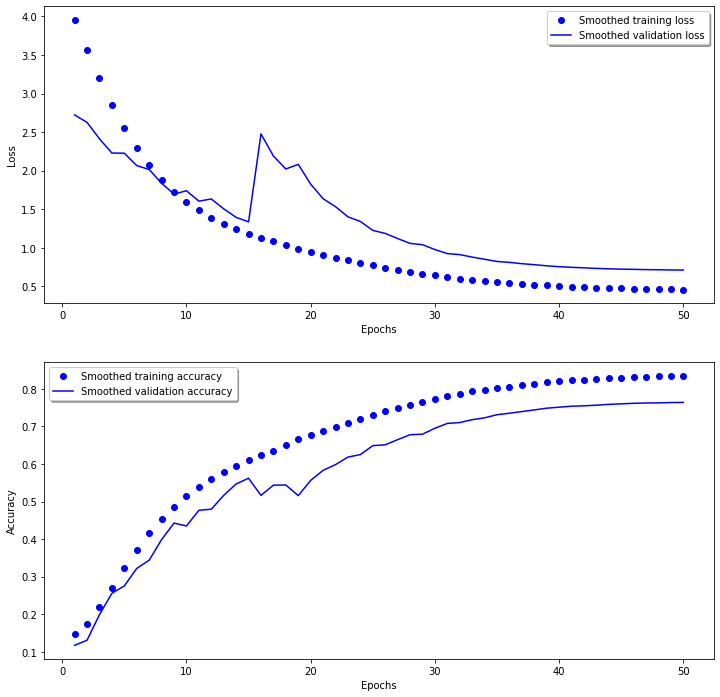

In [ ]:
# Visualisation:
plot_smoothed_learning_curves(history)

In [ ]:
#Load the best weights:
model.load_weights('/content/best_weight.h5')
with h5py.File('/content/drive/My Drive/3d/full_dataset_vectors.h5', 'r') as dataset:
    y_test = dataset["y_test"][:]
    x_test = dataset["X_test"][:]

(2000, 16, 16, 16, 3)
3D-CNN
[7.9018294e-14 1.8068626e-11 9.9999714e-01 4.7486758e-08 1.0695364e-08
 6.7118215e-08 4.0497037e-09 2.8179202e-06 3.0873963e-11 3.8430942e-12]
predicted 2
labels 2
accuracy score: 0.758


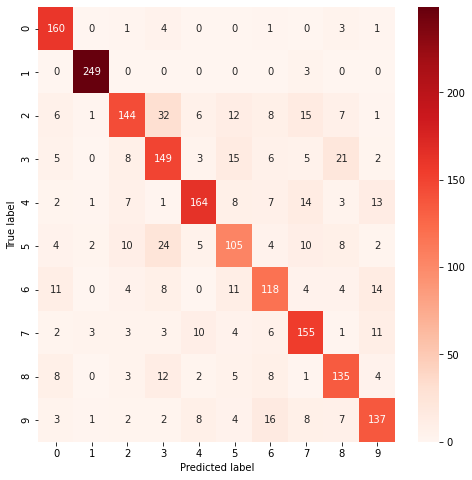

In [ ]:
def plot_confusion_matrix(model_name):
    # Predict the values from the validation dataset
    print(xtest.shape)
    print(model_name.name)
    y_pred = model_name.predict(xtest)
    print(y_pred[2])
    
    # Because Y_pred is an array of probabilities, we have to convert it to one hot vectors 
    y_pred = np.argmax(y_pred, axis = 1)
    print("predicted", y_pred[2])
    print("labels", y_test[2])
    
    #Compute and print the accuracy scores:
    
    print('accuracy score:', accuracy_score(y_test, y_pred))
    # compute the confusion matrix 
    # By definition a confusion matrix C is such that C_i,j is equal to the number of observations known to be in group i but predicted to be in group j.
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, index = range(10), columns = range(10))
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, cmap="Reds", annot=True, fmt= '.0f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

plot_confusion_matrix(model)

In [ ]:
!unzip /content/drive/'My Drive'/3d/239_748156_bundle_archive.zip -d /content/drive/'My Drive'/3d/

Archive:  /content/drive/My Drive/3d/239_748156_bundle_archive.zip
replace /content/drive/My Drive/3d/full_dataset_vectors.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

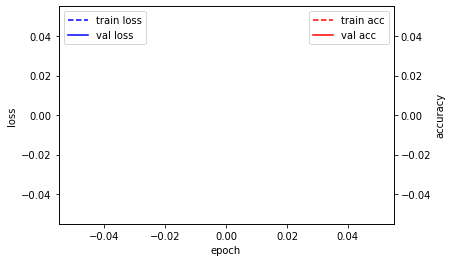

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(custom_hist.train_loss, 'b--', label='train loss')
loss_ax.plot(custom_hist.val_loss, 'b', label='val loss')

acc_ax.plot(custom_hist.train_acc, 'r--', label='train acc')
acc_ax.plot(custom_hist.val_acc, 'r', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='upper right')

plt.show()

In [ ]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
pred

array([7, 7, 2, ..., 6, 9, 8])